# Tic Tac Toe Environment

In [1]:
%%writefile tictactoe.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  5 18:09:47 2022

@author: heritianadanielandriasolofo
"""


class TicTacToe:
    def __init__(self) -> None:
        """Generate a Tic Tac Toe Game environment"""
        self.val = 1
        self.board = [[0] * 3 for _ in range(3)]
        self.number_of_empty = 9
        self.color = [0] * 8
        self.end = False
        self.winner = None
        self.actions = {
            0: (0, 0),
            1: (0, 1),
            2: (0, 2),
            3: (1, 0),
            4: (1, 1),
            5: (1, 2),
            6: (2, 0),
            7: (2, 1),
            8: (2, 2),
        }
        self.num_actions = 9

    def whose_turn(self):
        """Ask the environment the index of current player

        Returns:
            int: index of current player
        """
        return 0 if self.val == 1 else 1

    def get_reward(self, row, col):
        """Check wether the game is ended if current player play at the given position and return the respected reward.

        Args:
            row (int): row where player plays
            col (int): column where player plays

        Returns:
            int: reward obtain by playing at the given position
        """
        horizontal = (
            abs(self.board[row][0] + self.board[row][1] + self.board[row][2]) == 3
        )
        vertical = (
            abs(self.board[0][col] + self.board[1][col] + self.board[2][col]) == 3
        )
        diagonal = abs(self.board[0][0] + self.board[1][1] + self.board[2][2]) == 3
        antidiagonal = abs(self.board[0][2] + self.board[1][1] + self.board[2][0]) == 3

        reward = 0
        if self.number_of_empty == 0:
            self.end = True
            self.winner = None
        if horizontal:
            self.color[row] = self.val
            self.end = True
            self.winner = self.whose_turn()
            reward += 1
        if vertical:
            self.color[3 + col] = self.val
            self.end = True
            self.winner = self.whose_turn()
            reward += 1
        if diagonal:
            self.color[6] = self.val
            self.end = True
            self.winner = self.whose_turn()
            reward += 1
        if antidiagonal:
            self.color[7] = self.val
            self.end = True
            self.winner = self.whose_turn()
            reward += 1
        return reward

    def play(self, row, col):
        """Current player plays at the given row and column.

        Args:
            row (int): row where player want to play
            col (int): column where player want to play

        Returns:
            tuple[bool, int]: indication wether player was able to play at the given position, reward obtain by trying to play on the position
        """
        if self.end:
            return False, -2 * sum(self.color) - sum(self.color[6:])
        if not self.board[row][col] == 0:
            return False, -1  # penalize on typing on filled slot

        self.board[row][col] = self.val
        self.number_of_empty -= 1
        reward = self.get_reward(row, col)
        # switch player
        self.val *= -1
        return True, reward

    @property
    def hashed_state(self):
        """generate a hashed string for current state.

        Returns:
            str : hash for current state
        """
        return "".join("".join(map(lambda x: str(x % 3), row)) for row in self.board)

    def reset(self):
        """Reset environement:
        - Set hand to plalyer 1
        - Clear and uncolor the board

        Returns:
            str : empty state
        """
        self.val = 1
        self.board = [[0] * 3 for _ in range(3)]
        self.number_of_empty = 9
        self.color = [0] * 8
        self.end = False
        self.winner = None
        return self.hashed_state

    def step(self, action):
        """Make a step in the environement by performing an action.
        Actions are represented in a index form (from 0 to 8), where
        row 0, col 0 : action 0
        row 0, col 1 : action 1
        row 0, col 2 : action 2
        row 1, col 0 : action 3
        ...
        row 2, col 2 : action 8

        Args:
            action (int): index of the action to perform.


        Returns:
            tuple[str, int, bool, bool]: hashed of next state, reward from the action, indication if the game is done, indication if the player will be switched
        """
        switch, reward = self.play(*self.actions[action])
        return self.hashed_state, reward, self.end, switch


Overwriting tictactoe.py


# Utility funtions

In [2]:
%%writefile utils.py
import numpy as np
import json
from typing import *


def softmax(logits: np.ndarray):
    """Compute the softmax of a logits.

    Args:
        logits (np.ndarray): a 1-d array logits

    Returns:
        np.ndarray: probability distribution of the logits using softmax
    """
    exp_logits = np.exp(logits - logits.max())
    return exp_logits / np.sum(exp_logits)


def argmax_uniform(qvalue: np.ndarray):
    """Argmax function where the index will be chosen uniformely if there are more than one max

    Args:
        qvalue (np.ndarray): a 1-d array argument for the argmax function

    Returns:
        int: argmax chosen uniformely from all maximum
    """
    idx_max = np.arange(qvalue.shape[0])[qvalue == qvalue.max()]
    return np.random.choice(idx_max)


def return_probabilities(state: str, qvalue_state: np.ndarray, kind: str):
    """Generate a probability distribution of actions at a given state, knowing the Q-value

    If the state is for filled board, action 0 will be given.

    Args:
        state (str): current state
        qvalue_state (np.ndarray): `1-D`of the Q-value at the given state
        kind (str): one of the strings `'random'`, `'greedy'` or `'softmax'` which will be used to define the probability.

    Raises:
        NotImplementedError: raise Error if kind is not one of `'random'`, `'greedy'` and `'softmax'`

    Returns:
        list: the policy distribution at the given state
    """
    index_state = np.array([int(char) for char in state])
    probs = np.zeros_like(qvalue_state, dtype=np.float)
    logits = qvalue_state[index_state == 0]
    if len(logits) == 0:
        probs[0] = 1
        return probs.tolist()
    elif kind == "greedy":
        p = np.zeros_like(logits)
        idx_max = np.where(logits - logits.max() == 0)[0]
        p[idx_max] = 1 / len(
            idx_max
        )  # Give the same probability when there are more than one maximum
    elif kind == "softmax":
        p = softmax(logits)
    elif kind == "random":
        p = 1 / len(logits)
    else:
        raise NotImplementedError
    probs[index_state == 0] = p
    return probs.tolist()


def generate_json_policy(policy: dict, json_policy_path: str):
    """Generate a json file of the policy dictionary

    Args:
        policy (dict): a policy of an agent
        json_policy_path (str): a path where the json file will be stored
    """
    with open(json_policy_path, "w") as json_file:
        json.dump(policy, json_file, indent=2)


def read_json_policy(json_policy_path: str):
    """Generate a policy in a dictionary from a json file

    Args:
        json_policy_path (str): path where the json file is stored

    Returns:
        dict[str: list]: a policy dictionary with states (`str`) as keys and action distributions (`list`) as values
    """
    with open(json_policy_path, "r") as json_file:
        policy = json.load(json_file)
    return policy


Overwriting utils.py


# Player module

In [3]:
%%writefile player_module.py
import numpy as np
import json
from typing import *
from utils import return_probabilities, generate_json_policy, argmax_uniform


class Player:
    def act(self, state: str):
        """Player will generate action depending on the state

        Args:
            state (str): current state
        """
        pass

    def update(
        self, state: str, action: int, next_state: str, reward: int, done: bool
    ) -> None:
        """Update function for the qfunction at a given `state` with a given
        `action` which takes it to a given state (`next_state`) and obtain a
        reward `reward` and a flag `done` saying wether the new state is a
        terminal sate or not.

        Args:
            state (str): current state
            action (int): action to perfom
            next_state (str): next state after performing the action at the state
                                reward (int): reward obtained by performing the action at the state
            done (bool): falg saying wether the next state is a terminal state or not
        """
        pass


class HumanPlayer(Player):
    def __init__(self, player_number: int, name: str = None):
        """This is the class of human player

        Args:
            player_number (int): either 1 or 2, which says the player
                                    if the first player or the second
            name (str, optional): name of the player. Defaults to None.
                                    If none is given, the player will
                                    be `Player1` or `Player2` depending on their number
        """
        super().__init__()
        self.player_number = player_number
        self.name = name if name else f"Player{player_number}"

    def act(self, state: str, *args, **kwargs):
        """It will ask the human players to choose action that they will take
        by giving the corresponding value shown in the board

        Args:
            state (str): current state

        Returns:
            int: the action that user will take
        """
        print(
            f"{self.name}, it is your turn. You are {('X','+')[self.player_number-1]}."
        )
        available_actions = []
        table = ""
        for action, state_number in zip(range(9), state):
            s_num = int(state_number)
            if s_num == 0:
                available_actions.append(action)
            symbols = (str(action), "X", "+")
            table += symbols[s_num] + " "
            if action in (2, 5):
                table += "\n"
        print(table)

        while True:
            action = int(input(f"Choose your action {available_actions}:\t").strip())
            if action in available_actions:
                break
        print("->", action)

        return action


class QAgent(Player):
    def __init__(
        self,
        num_actions: int,
        gamma: float,
        learning_rate: float,
        epsilon: float,
        qfunction: dict = None,
    ) -> None:
        """A free tabular Q-agent class for Tic Tac Toe player

        Args:
            num_actions (int): the total number of actions for the environment
            gamma (float): discount factor (between 0 to 1, 1 excluded from theory).
                            The higher gamma is, the more the agent look at a bigger horizon.
            learning_rate (floar): learning rate for update Q-function (from 0 to 1).
                                    The higher learning rate is, the higher exploitation.
            epsilon (float): probability of acting non greedily (from 0 to 1). The higher epsilon is,
                            the more the agent explore.
            qfunction (dict): Q-value function of each state at each action. Default to None.
        """
        self.set_learning_params(gamma, learning_rate, epsilon)
        self.qfunction = qfunction if qfunction is not None else {}
        self._num_actions = num_actions

    def set_learning_params(
        self, gamma: float = None, learning_rate: float = None, epsilon: float = None
    ):
        """Setting learning parameters.
        At least one of the parameters is given.

        Args:
            gamma (float, optional): discount factor (between 0 to 1, 1 excluded from theory).
                            The higher gamma is, the more the agent look at a bigger horizon.
            learning_rate (float, optional): learning rate for update Q-function (from 0 to 1).
                                    The higher learning rate is, the higher exploitation.
            epsilon (float, optional): probability of acting non greedily (from 0 to 1). The higher epsilon is,
                            the more the agent explore.
        """
        assert gamma or learning_rate or epsilon
        if gamma is not None:
            self._gamma = gamma
        if learning_rate is not None:
            self._alpha = learning_rate
        if epsilon is not None:
            self._epsilon = epsilon

    def act(self, state: str, eval: bool = False, policy: dict = None):
        """Sample action at a given state

        Args:
            state (str): state where to chose a sample action according to
                            the `qfunction` and the `eval` flag.
            eval (bool, optional): a flag saying wether the sampling should be
                                    done greedily (if `eval` is set to `True`) or epsilon-greedy. Defaults to False.
            policy (dict, optional): a dictionary policy to use if it is not None. Default to None. If policy is given
                                    then eval will be ignored. If the given state is not available in the policy, action
                                    will be choosen uniformly from all allowed move.

        Returns:
            int: a sample action at the given state.
        """
        if policy is not None and isinstance(policy, dict):
            if state in policy:
                proba = policy[state]
            else:
                proba = return_probabilities(
                    state, np.zeros(self._num_actions), "random"
                )
            action = np.random.choice(np.arange(self._num_actions), p=proba)
            return action

        if state not in self.qfunction:
            self.qfunction[state] = np.array(
                return_probabilities(state, np.zeros(self._num_actions), "random")
            )

        if eval or np.random.uniform() > self._epsilon:
            action = argmax_uniform(self.qfunction[state])  # grab argmax uniformely
        else:
            action = np.random.randint(self._num_actions)
        return action

    def update(
        self, state: str, action: int, next_state: str, reward: int, done: bool
    ) -> None:
        """Update function for the qfunction at a given `state` with a given `action`
        which takes it to a given state (`next_state`) and obtain a reward `reward` and a flag `done` saying wether the .
        the new state is a terminal sate or not.

        Args:
            state (str): current state
            action (int): action to perfom
            next_state (str): next state after performing the action at the state
            reward (int): reward obtained by performing the action at the state
            done (bool): falg saying wether the next state is a terminal state or not
        """
        if state not in self.qfunction:
            self.qfunction[state] = np.array(
                return_probabilities(state, np.zeros(self._num_actions), "random")
            )

        if done:
            self.qfunction[state][action] = (1 - self._alpha) * self.qfunction[state][
                action
            ] + self._alpha * reward
        else:
            if next_state not in self.qfunction:
                self.qfunction[next_state] = np.array(
                    return_probabilities(
                        next_state, np.zeros(self._num_actions), "greedy"
                    )
                )
            self.qfunction[state][action] = (1 - self._alpha) * self.qfunction[state][
                action
            ] + self._alpha * (reward + self._gamma * self.qfunction[next_state].max())

    def save_qfunction(self, json_qfunction_path: str):
        """Save Q function in a json file

        Args:
            json_qfunction_path (str): path where json file will be saved
        """
        dumped = {state: qvalue.tolist() for state, qvalue in self.qfunction.items()}
        with open(json_qfunction_path, "w") as f:
            json.dump(dumped, f)

    def generate_policy(self, kind: str, json_policy_path: str = None):
        """Generate a policy of an agent from its qfunction.

        Args:
            kind (str): one of the strings `'random'`, `'greedy'` or `'softmax'`
                        which will be used to define the probability.
            json_policy_path (str, optional): A path to save the policy as a json file.
                                                Defaults to None. If it is none, then the policy
                                                will only be returned as a dictionary.

        Returns:
            dict: generated policy
        """
        policy = {}
        for state, qvalue in self.qfunction.items():
            policy[state] = return_probabilities(
                state=state, qvalue_state=qvalue, kind=kind
            )
        if json_policy_path is not None:
            generate_json_policy(policy, json_policy_path)
        return policy


Overwriting player_module.py


# Train module

In [4]:
%%writefile train_module.py
from player_module import Player, HumanPlayer
from tictactoe import TicTacToe

from typing import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def run_episode(
    player1: Player,
    player2: Player,
    environment: TicTacToe,
    eval1: bool = False,
    eval2: bool = False,
    max_step: int = 100,
):
    """Runing episode between two adgents players.

    Args:
        player1 (Player): first QAgent player
        player2 (Player): second QAgent player
        environment (TicTacToe): the tic tac toe environment where the two agents will play
        eval1 (bool, optional): flag saying wether player1 is in an evaluation or training mode.
                        If it is an evaluation, then player1 will play greedily, otherwise
                        epsilon-greedy with update. Defaults to False i.e. training.
        eval2 (bool, optional): flag saying wether player2 is in an evaluation or training mode.
                        If it is an evaluation, then player2 will play greedily, otherwise
                        epsilon-greedy with update. Defaults to False i.e. training.
        max_step (int, optional): maximum step allowed for the episode. Defaults to 100.

    Returns:
        tuple(list[int,int], int): where the list will contain the reward of player1 and player2
                                    respectedly during the episode. The second element is an
                                    integer (1 or 2) value of the  winner. It will be 0 if it is a draw.
    """
    state = environment.reset()
    n_steps = 0
    players = [player1, player2]
    evals = (eval1, eval2)
    rewards = [0, 0]
    dones = [False, False]
    done = False
    p = 0
    winners = []
    while True:
        eval = evals[p]
        if done and isinstance(players[p], HumanPlayer):
            action = 0
        else:
            action = players[p].act(state, eval=eval)
        next_state, reward, done, switch = environment.step(action)

        if not eval:
            players[p].update(state, action, next_state, reward, done)
        rewards[p] += reward
        dones[p] = done
        if done:
            winners.append(p + 1)
        n_steps += 1
        state = next_state
        if all(dones) or n_steps > max_step:
            break
        if switch:  # do not pass the hand until player put in an empty place
            p = int(not p)
    winner = winners[0] if winners else 0
    return rewards, winner


def train(
    player1: Player,
    player2: Player,
    environment: TicTacToe,
    num_episodes: int,
    eval_every_N: int,
    num_eval_episodes: int,
    eval1: bool = False,
    eval2: bool = False,
    max_step: int = 100,
):
    """Train QAgent player

    Args:
        player1 (Player): first player
        player2 (Player): _description_
        environment (TicTacToe): the tic tac toe environment where the two agents will play
        num_episodes (int): number of episodes to do for the training
        eval_every_N (int): episode period for evaluation
        num_eval_episodes (int): number of episode for each evaluation
        eval1 (bool, optional): flag saying wether player1 is in an evaluation or training mode.
                        If it is an evaluation, then player1 will play greedily, otherwise
                        epsilon-greedy with update. Defaults to False i.e. training.
        eval2 (bool, optional): flag saying wether player2 is in an evaluation or training mode.
                        If it is an evaluation, then player2 will play greedily, otherwise
                        epsilon-greedy with update. Defaults to False i.e. training.
        max_step (int, optional): maximum step allowed for the episode. Defaults to 100

    Returns:
        tuple[list, np.ndarray, np.darray]: - list of episodes number during evaluation
                                            - 2-d array of average reward for each evaluation
                                            - 2-d array of average number of [draw, player1 wins, player2 wins]
                                            for each evaluation during training
    """
    there_is_a_human_player = isinstance(player1, HumanPlayer) or isinstance(
        player2, HumanPlayer
    )
    all_rewards = []
    episodes = []
    winners = []
    print("\nYou can choose to stop training at any time by interrupting.")
    try:
        for episode in tqdm(range(num_episodes)):
            if there_is_a_human_player:
                print(f"\n\n---------- Episode : {episode} ----------")
            run_episode(
                player1,
                player2,
                environment,
                eval1=eval1,
                eval2=eval2,
                max_step=max_step,
            )

            if episode % eval_every_N == 0:
                if there_is_a_human_player:
                    print("\n-----Running evaluation-----\n")
                rewards_list = []
                winners_list = [0, 0, 0]
                for _ in range(num_eval_episodes):
                    rewards, winner = run_episode(
                        player1,
                        player2,
                        environment,
                        eval1=True,
                        eval2=True,
                        max_step=max_step,
                    )
                    rewards_list.append(rewards)
                    winners_list[winner] += 1
                rewards = np.mean(rewards_list, axis=-1)
                winners.append(winners_list.copy())
                all_rewards.append(rewards)
                episodes.append(episode)
    except KeyboardInterrupt:
        pass

    all_rewards = np.array(all_rewards).T
    winners = np.array(winners).T
    return episodes, all_rewards, winners


def visualize_rewards(
    episodes: list,
    all_rewards: np.ndarray,
    num_eval_episodes: int,
    name1: str = None,
    name2: str = None,
    from_index: int = 0,
    end_index: int = -1,
):
    """Reward visualization for the evaluation during training

    Args:
        episodes (list): list of episode number of traing for evaluation
        all_rewards (np.ndarray): average reward of both players for each evaluation
                                    during training
        num_eval_episodes (int): number of episode for each evaluation
        name1 (str, optional): name of player 1. Defaults to None. If None is given,
                                it will be `Player 1`
        name2 (str, optional): name of player 2. Defaults to None. If None is given,
                                it will be `Player 2`
        from_index (int, optional): start index. Defaults to 0.
        end_index (int, optional): end index. Defaults to -1.
    """
    if not name1:
        name1 = "Player 1"
    if not name2:
        name2 = "Player 2"
    plt.figure(figsize=(15, 6))
    plt.title(f"Average rewards over {num_eval_episodes} episodes")
    plt.xlabel("Number of training episodes")
    plt.ylabel(f"Average rewards")
    plt.plot(
        episodes[from_index:end_index],
        all_rewards[0][from_index:end_index],
        "--",
        label=name1,
    )
    plt.plot(
        episodes[from_index:end_index],
        all_rewards[1][from_index:end_index],
        ":",
        label=name2,
    )
    plt.legend()
    plt.show()


def visuzalize_winners(
    winners: np.ndarray[int],
    num_eval_episodes: int,
    name1: str = None,
    name2: str = None,
    from_index: int = 0,
    end_index: int = -1,
):
    """Histogram visualization of number episode time players win for each evaluation

    Args:
        winners (np.ndarray): `3xn`-array number of time for draw or player 1 or 2 wins for each
                                evaluation
        num_eval_episodes (int): number of episode for each evaluation
        name1 (str, optional): name of player 1. Defaults to None. If None is given,
                                it will be `Player 1`
        name2 (str, optional): name of player 2. Defaults to None. If None is given,
                                it will be `Player 2`
        from_index (int, optional): start index. Defaults to 0.
        end_index (int, optional): end index. Defaults to -1.

    Returns:
        str: percentage of draw and winning time of both players
    """
    if not name1:
        name1 = "Player 1"
    if not name2:
        name2 = "Player 2"
    plt.figure(figsize=(15, 6))
    plt.title("Histogram of number of time Player's win.")
    plt.hist(winners[1][from_index:end_index], label=name1)
    plt.hist(winners[2][from_index:end_index], label=name2)
    plt.hist(winners[0][from_index:end_index], label="Draw")
    plt.legend()
    plt.show()

    draw, p1, p2 = (
        np.mean(winners[:, from_index:end_index], axis=-1) * 100 / num_eval_episodes
    )
    return f"{draw:.2f}% is Draw\n{p1:.2f}% {name1} wins\n{p2:.2f}% {name2} wins"


Overwriting train_module.py


# Import necessary libraries

In [5]:
from tictactoe import TicTacToe
from player_module import QAgent, HumanPlayer
from train_module import run_episode, train, visualize_rewards, visuzalize_winners
import numpy as np

# Training QAgents

## Generate TicTacToe environment

In [6]:
print("Generating TicTacToe environment for training...", end=" ")
environment = TicTacToe()
print("[Done]")

Generating TicTacToe environment for training... [Done]


## Train a model : Agent vs Agent

Train two models against each other 

### Set training hyper-params

In [7]:
gamma=.999 # @param horizon
learning_rate=0.01 # @param exploitation
epsilon= .8 # @param exploration

In [8]:
num_episodes = 500000 # @param number of episode during training
max_step = 100000 # @param maximum number of step in an episode
eval_every_N = 5 # @param evaluation period
num_eval_episodes = 10 # @param number of episode to run in each evaluation

### Prepare for training

In [9]:
print("Generating Player1 agent...", end=" ")
player1 = QAgent(environment.num_actions, gamma=gamma, learning_rate=learning_rate, epsilon= epsilon)
print("[Done]")
print("Generating Player2 agent...", end=" ")
player2 = QAgent(environment.num_actions, gamma=gamma, learning_rate=learning_rate, epsilon= epsilon)
print("[Done]")
print()
print("Ready for training")

Generating Player1 agent... [Done]
Generating Player2 agent... [Done]

Ready for training


### Start training both

In [10]:
print("-"*10, "BEGIN TRAINING", "-"*10)
episodes, all_rewards, winners = train(player1=player1, player2=player2, environment=environment, 
                                num_episodes=num_episodes, eval_every_N=eval_every_N, 
                                num_eval_episodes=num_eval_episodes, eval1=False, eval2=False, max_step=max_step)
print("-"*10, "END TRAINING", "-"*10)


---------- BEGIN TRAINING ----------

You can choose to stop training at any time by interrupting.


100%|██████████| 500000/500000 [02:25<00:00, 3429.95it/s]

---------- END TRAINING ----------


### First training visualization

In [11]:
from_index = len(episodes)-100
end_index = -1

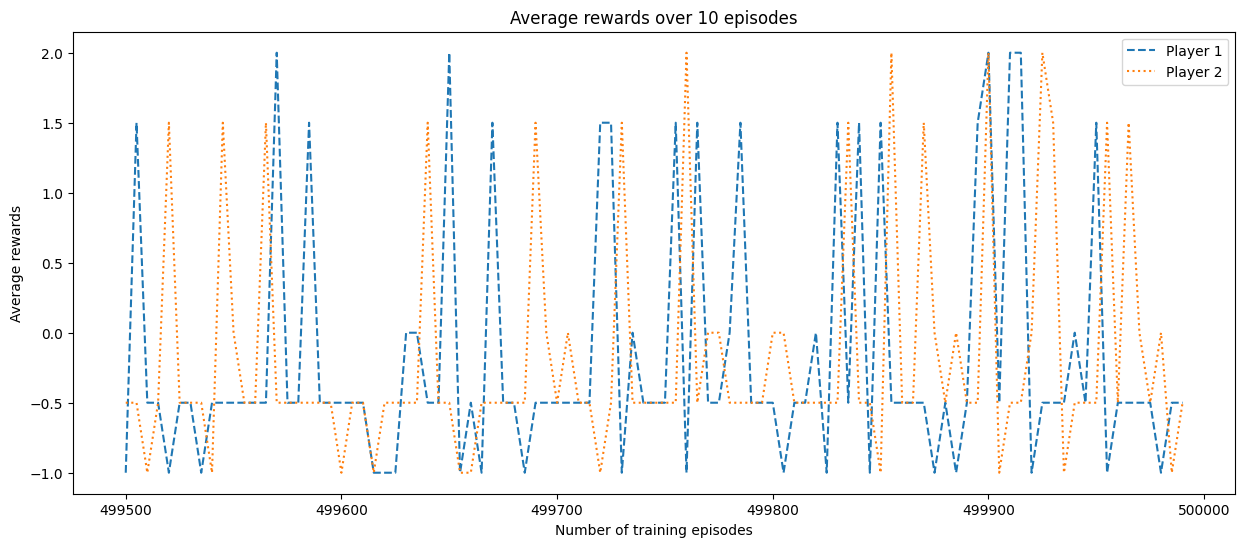

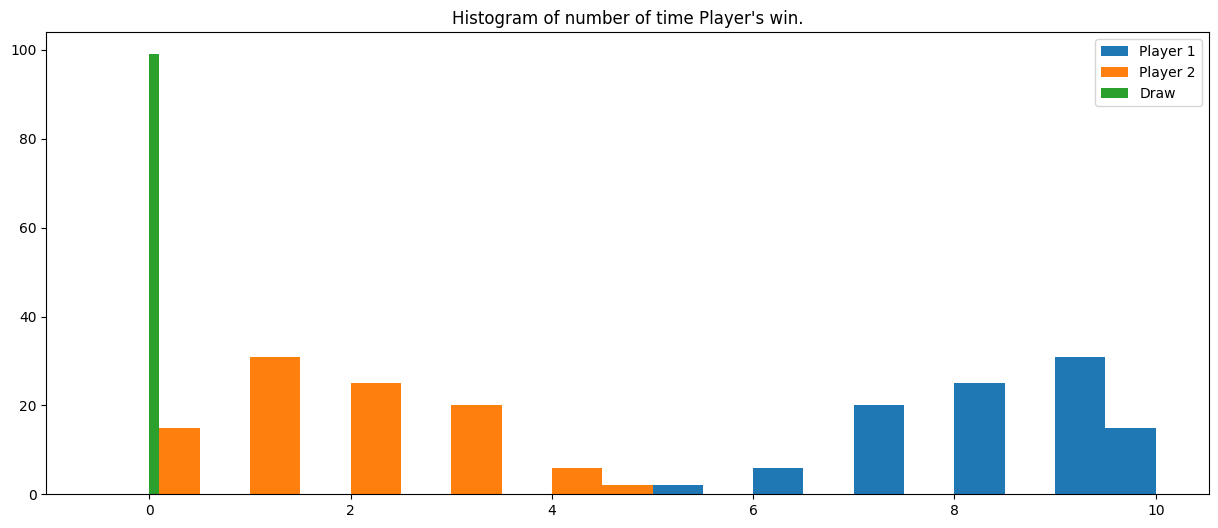

0.00% is Draw
82.32% Player 1 wins
17.68% Player 2 wins


In [12]:
visualize_rewards(episodes, all_rewards, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
stats = visuzalize_winners(winners, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
print(stats)

### Start training Player 2 while Player 1 is freezed

In [13]:
gamma=.999 # @param horizon
learning_rate=0.1 # @param exploitation
epsilon= .5 # @param exploration
max_step = 100000 # @param maximum number of step in an episode

player2.set_learning_params(gamma, learning_rate, epsilon)

In [14]:
print("-"*10, "BEGIN TRAINING Player 2", "-"*10)
episodes, all_rewards, winners = train(player1=player1, player2=player2, environment=environment, 
                                num_episodes=num_episodes, eval_every_N=eval_every_N, 
                                num_eval_episodes=num_eval_episodes, eval1=True, eval2=False, max_step=max_step)
print("-"*10, "END TRAINING", "-"*10)

---------- BEGIN TRAINING Player 2 ----------

You can choose to stop training at any time by interrupting.


100%|██████████| 500000/500000 [02:18<00:00, 3616.82it/s]


---------- END TRAINING ----------


### Second training visualization

In [15]:
from_index = len(episodes)-100
end_index = -1

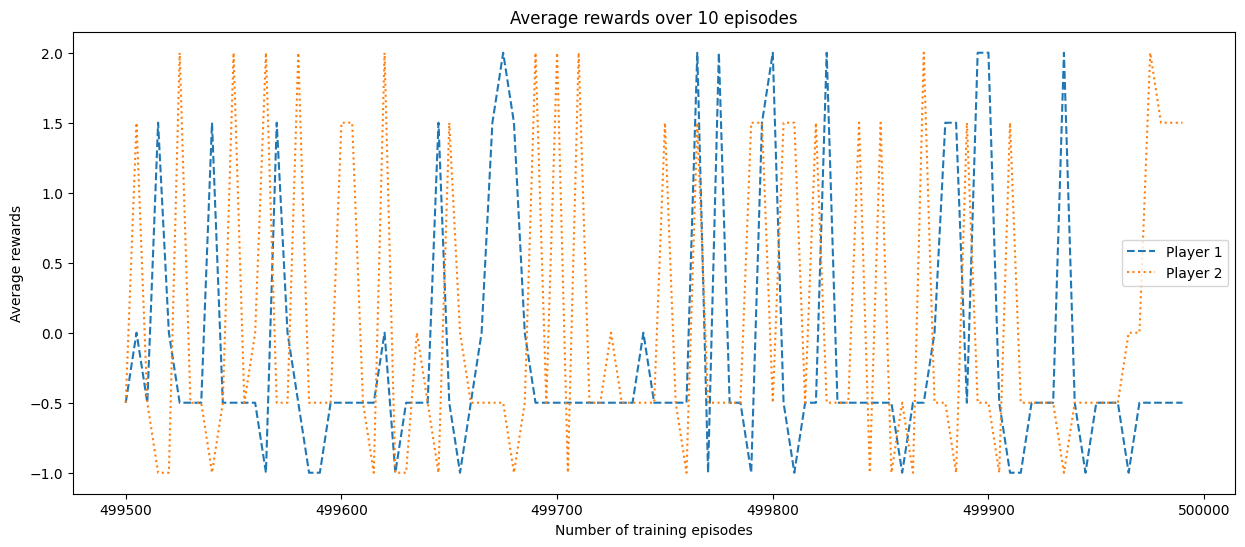

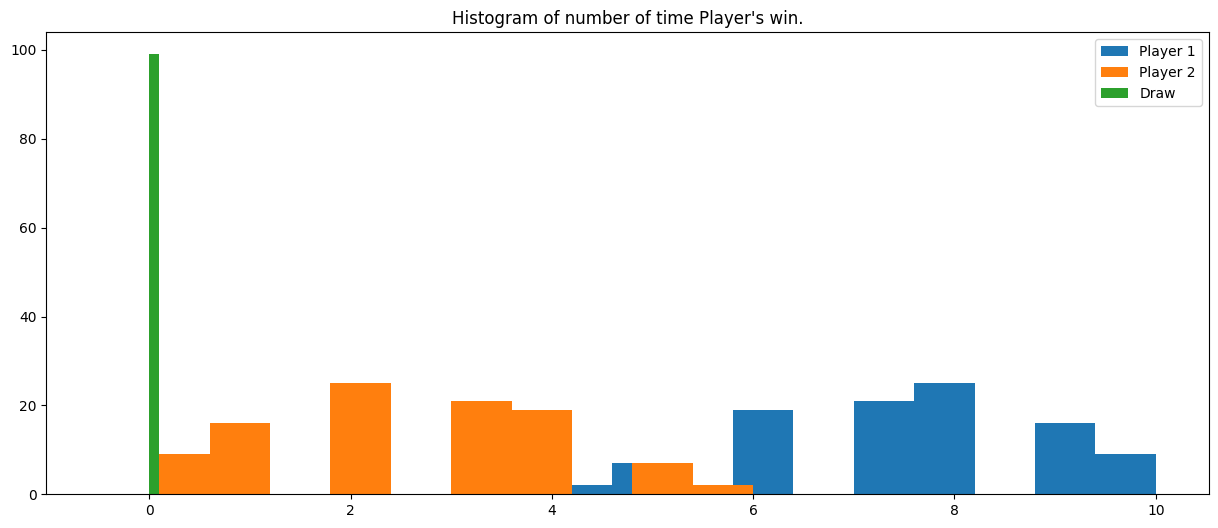

0.00% is Draw
74.55% Player 1 wins
25.45% Player 2 wins


In [16]:
visualize_rewards(episodes, all_rewards, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
stats = visuzalize_winners(winners, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
print(stats)

### Start training Player 1 while Player 2 is freezed

In [17]:
gamma=.999 # @param horizon
learning_rate=0.0001 # @param exploitation
epsilon= .5 # @param exploration
num_episodes = 10000 # @param number of episode during training
max_step = 1000 # @param maximum number of step in an episode

player1.set_learning_params(gamma, learning_rate, epsilon)

In [18]:
print("-"*10, "BEGIN TRAINING Player 1", "-"*10)
episodes, all_rewards, winners = train(player1=player1, player2=player2, environment=environment, 
                                num_episodes=num_episodes, eval_every_N=eval_every_N, 
                                num_eval_episodes=num_eval_episodes, eval1=False, eval2=True, max_step=max_step)
print("-"*10, "END TRAINING", "-"*10)

---------- BEGIN TRAINING Player 1 ----------

You can choose to stop training at any time by interrupting.


100%|██████████| 10000/10000 [00:02<00:00, 3572.81it/s]

---------- END TRAINING ----------


### Third training visualization

In [19]:
from_index = len(episodes)-100
end_index = -1

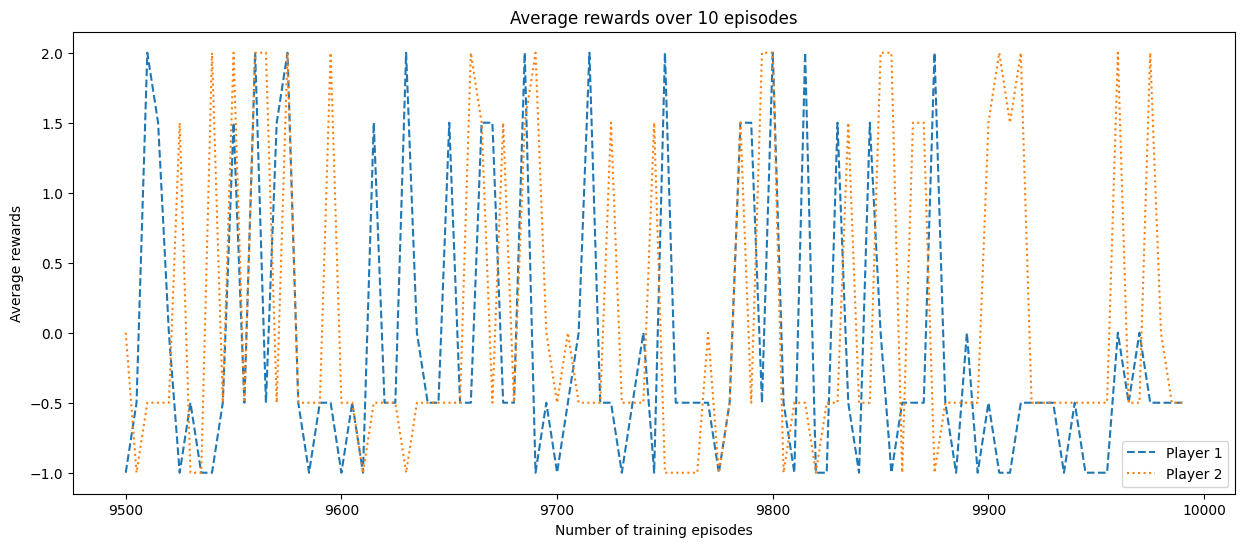

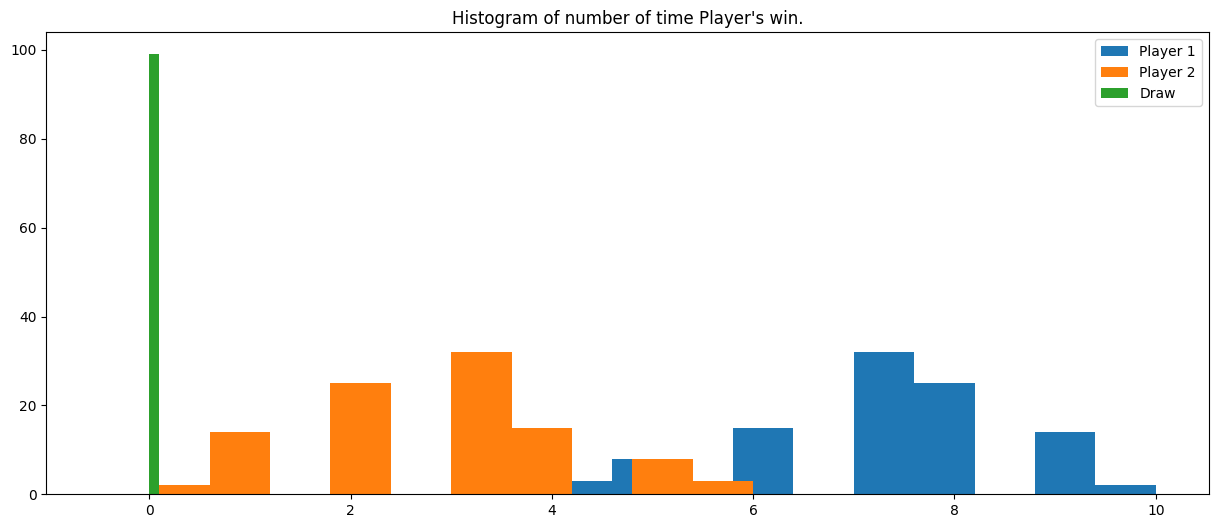

0.00% is Draw
71.92% Player 1 wins
28.08% Player 2 wins


In [20]:
visualize_rewards(episodes, all_rewards, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
stats = visuzalize_winners(winners, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)
print(stats)

## Train Agent vs Human

### Update parameters setup

In [21]:
gamma=.999 # @param horizon
learning_rate=0.1 # @param exploitation
epsilon= .5 # @param exploration

In [22]:
num_episodes = 1 # @param number of episode during training
max_step = 1000 # @param maximum number of step in an episode
eval_every_N = 1 # @param evaluation period
num_eval_episodes = 1 # @param number of episode to run in each evaluation

### Give human player's name

In [23]:
train_against_human = False # @param set true to train model manually
name_human_player = "Heritiana" # @param

### Train player1 agent with Human

In [24]:
if train_against_human:
    print("Setting new params...", end=" ")
    player1.set_learning_params(gamma, learning_rate, epsilon)
    print("[Done]")
    print("Generating human player as a second player...", end=" ")
    human_player = HumanPlayer(2, name_human_player)
    print("[Done]")

    print()
    print("-"*10, "BEGIN TRAINING", "-"*10)
    episodes1, all_rewards1, winners1 = train(player1, human_player, environment, num_episodes,
                                        eval_every_N, num_eval_episodeseval1=False, eval2=True, max_step=max_step)
    print("-"*10, "END TRAINING", "-"*10)

### Train player2 agent with Human

In [25]:
if train_against_human:
    print("Setting new params...", end=" ")
    player2.set_learning_params(gamma, learning_rate, epsilon)
    print("[Done]")
    print("Generating human player as a first player...", end=" ")
    human_player = HumanPlayer(1, name_human_player)
    print("[Done]")


    print()
    print("-"*10, "BEGIN TRAINING", "-"*10)
    episodes2, all_rewards2, winners2 = train(human_player, player2, environment, num_episodes,
                                        eval_every_N, num_eval_episodes, eval1=True, eval2=False, max_step=max_step)
    print("-"*10, "END TRAINING", "-"*10)

### Training visualization

In [26]:
if train_against_human:
    from_index = 0
    end_index = -1

In [27]:
if train_against_human:
    visualize_rewards(episodes1, all_rewards1, num_eval_episodes, name1 = None, name2=name_human_player, 
                        from_index=from_index, end_index=end_index)
    visuzalize_winners(winners1, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)

In [28]:
if train_against_human:
    visualize_rewards(episodes2, all_rewards2, num_eval_episodes, name1 = name_human_player,
                        name2=None, from_index=from_index, end_index=end_index)
    visuzalize_winners(winners2, num_eval_episodes, name1 = None, name2=None, from_index=from_index, end_index=end_index)

# Generate policies as json files

## Set directory for saving files

In [29]:
policy_dir = "../src/policy/"
qvalue_dir = "../src/qvalue/"

# Serialize Q-function

In [30]:
player1.save_qfunction(qvalue_dir + "player1_qvalue.json")
player2.save_qfunction(qvalue_dir + "player2_qvalue.json")
print("Q-function saved successfully")

Q-function saved successfully


## Generate easy-level policy

In [31]:
easy = player1.generate_policy(kind = "random",json_policy_path = policy_dir + "easy.json")

print("Random policy generated successfully")

Random policy generated successfully


## Generate medium-level policies

In [32]:
player1.generate_policy(kind = "softmax", json_policy_path = policy_dir + "medium_player1.json")
player2.generate_policy(kind = "softmax", json_policy_path = policy_dir + "medium_player2.json")
print("Medium policy generated successfully")

Medium policy generated successfully


## Generate hard-level policies

In [33]:
player1.generate_policy(kind = "greedy", json_policy_path = policy_dir + "hard_player1.json")
player2.generate_policy(kind = "greedy", json_policy_path = policy_dir + "hard_player2.json")
print("Hard policy generated successfully")

Hard policy generated successfully
